In [1]:
from approximations import *
from aspergillus_msb import *
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import ParameterGrid
from scipy.spatial.distance import hamming
from scipy.spatial import distance

In [2]:
def calc_s(IG, val):
    return((IG-val)/IG)

In [3]:
with open('aspergillus_landscape.txt', 'rb') as f:
    landscape = pickle.load(f)
landscape['00011010'] = 0.0
with open('local_maxima_aspergillus.txt', 'rb') as f:
    local_maxima = pickle.load(f)
file = 'results_aspergillus_msb_2.txt'
with open(file, 'rb') as f:
    results = pickle.load(f)

In [4]:
genotypes = [tuple(x) for x in landscape.keys()]

all_genotypes = []
for i in range(2):
    for g in genotypes:
        all_genotypes.append((i, g))
        
params = {'mu': [1e-7, 1e-6, 1e-5], 'tau': [10, 100]}
params = list(ParameterGrid(params))
initial_genotype = tuple(list(local_maxima.keys())[2])
noise_levels = np.logspace(-6,np.log10(0.5), 30)

In [5]:
IG = tuple('10010000')

In [6]:
one_n = [all_genotypes.index((0,x)) for x in [g for g in genotypes if hamming(g,IG) == 1/8]] + [all_genotypes.index((1,x)) for x in [g for g in genotypes if hamming(g, IG) == 1/8]]

In [7]:
one_n

[1, 4, 38, 43, 48, 49, 50, 51, 257, 260, 294, 299, 304, 305, 306, 307]

In [8]:
fitness_neighbors = []
for g in genotypes:
    if hamming(IG, g) == 1/8:
        fitness_neighbors.append(landscape["".join(g)])

In [9]:
fitness_neighbors

[0.751, 0.757, 0.0, 0.576, 0.735, 0.0, 0.522, 0.706]

In [10]:
sorted_neighbors = np.sort(fitness_neighbors)[::-1]

In [11]:
def calculate_rate_appearance_approximation(noise, mu, tau, s, bridges):
    B = len(bridges)
    
    M1 = calculate_M1(noise, mu*8,tau,s)
    m1 = calculate_m1(noise, mu*8,tau,s)
    
    from_M1 = (B/8)*tau*mu*((1-tau*mu)**5)*M1
    from_m1 = (B/8)*mu*((1-mu)**5)*m1
    
    #return(from_M1+from_m1)
    return(from_M1)

def calculate_rate_appearance(all_genotypes, landscape, param, noise):
   
    mu, tau = results[param]['mu'], results[param]['tau']
    population = results[param]['result'][noise]['pop']
    genotypes = [tuple(x) for x in landscape.keys()]
    
    # calculate possible adaptations
    possible_dm = [g for g in genotypes if (hamming(g, list(initial_genotype)) == 2/len(initial_genotype)) and landscape["".join(g)]>landscape["".join(initial_genotype)]]

    # calculate intermediate one mutants between adaptations
    possible_inter = []
    for dm in possible_dm:
        intermediates = [g for g in genotypes if (hamming(g, list(initial_genotype)) == 1/len(initial_genotype)) and (hamming(g, list(dm)) == 1/len(initial_genotype))]
        for i in intermediates:
            for mr in range(2):
                possible_inter.append((mr,i))

    # calculate M1, m1
    rate_appearance = 0
    for inter in possible_inter:
        index = all_genotypes.index(inter)
        if inter[0] == 0:
            rate_appearance += mu * ((1-mu)**(len(inter[1])-1)) * population[index]
        elif inter[0] == 1:
            rate_appearance += tau*mu * ((1-tau*mu)**(len(inter[1])-1)) * population[index]

    # return rate of appearance
    return(rate_appearance)

In [12]:
selection_coefficients = [calc_s(landscape["".join(IG)], np.mean(sorted_neighbors[:n])) for n in range(1,9)]

### Calculate All Approximations

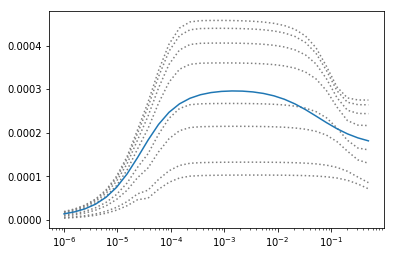

In [13]:
all_approximations = []

for i in range(len(selection_coefficients)):
    M1_2 = np.array([calculate_M1(noise_levels[x], 8*results[2]['mu'], results[2]['tau'],selection_coefficients[i]) for x in range(30)])
    M1_3 =  np.array([calculate_M1(noise_levels[x], 8*results[3]['mu'], results[3]['tau'],selection_coefficients[i]) for x in range(30)])

    m1_2 =  np.array([calculate_m1(noise_levels[x], 8*results[2]['mu'], results[2]['tau'],selection_coefficients[i]) for x in range(30)])
    m1_3 =  np.array([calculate_m1(noise_levels[x], 8*results[3]['mu'], results[3]['tau'],selection_coefficients[i]) for x in range(30)])
    
    approx_2 = 1e5*((np.array(m1_2) * results[2]['mu'] * (1-results[2]['mu'])**7) + (np.array(M1_2) * results[2]['mu']*results[2]['tau'] * (1-results[2]['mu']*results[2]['tau'])**7))
    
    all_approximations.append(approx_2)
    
    plt.plot(noise_levels, approx_2, c = 'grey', linestyle = 'dotted')
    
    
plt.plot(noise_levels, [1e5*calculate_rate_appearance(all_genotypes, landscape, 2, noise) for noise in range(30)], linewidth = '1.5')
plt.xscale('log')

plt.show()

### Calculating Euclidean Distance

In [14]:
numerical =  [1e5*calculate_rate_appearance(all_genotypes, landscape, 2, noise) for noise in range(30)]

In [15]:
distances = [distance.euclidean(numerical, all_approximations[i]) for i in range(len(selection_coefficients))]

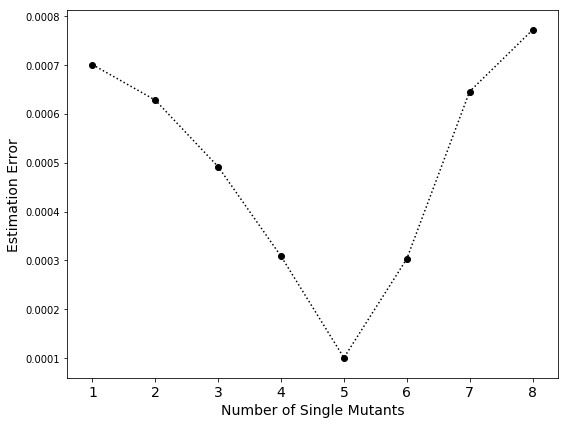

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8.,6.))
ax.plot(distances, c = 'k', linestyle = 'dotted')
ax.scatter(range(len(selection_coefficients)), distances, c = 'k')
ax.set_xticks(range(len(selection_coefficients)))
ax.set_xticklabels(range(1,len(selection_coefficients)+1), fontsize = 14)
ax.set_xlabel('Number of Single Mutants', fontsize = 14)
ax.set_ylabel('Estimation Error', fontsize = 14) 

plt.tight_layout()
plt.savefig('Optimization_s_calculation_aspergillus_new.jpg', dpi = 300)

plt.show()

In [64]:
selection_coefficients

[0.08795180722891562,
 0.09156626506024092,
 0.09919678714859442,
 0.11174698795180724,
 0.15060240963855423,
 0.18734939759036143,
 0.30344234079173843,
 0.3905120481927711]